<a id="imports"></a>

# Spotify + Billboard Hot 100

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


from IPython.display import display, Markdown

from wrangle import *

# Acquire <a id="acquire"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [ ]:
# acquire()

In [2]:
# A C Q U I R E  -  MAIN FUNCTION
# ==================================================

# use my load_csv_file() function
hot_100 = pd.read_csv("hot_100.csv")
spotify_popular = pd.read_csv("songs_normalize.csv")

# C L E A N  -  MAIN FUNCTION
# ==================================================

# date type column
hot_100['chart_date']=pd.to_datetime(hot_100['chart_date'])

# set date column as index
hot_100 = hot_100.set_index("chart_date").sort_index()
hot_100_2000_2020 = hot_100.loc['2000-01-01':'2020-12-31']

# create song index
hot_100_2000_2020["song_index"] = hot_100_2000_2020["performer"].str.lower() + " - " + hot_100_2000_2020["song"].str.lower()

#saving extra copy of date before grouping by index
hot_100_2000_2020['date'] = hot_100_2000_2020.index

# Removing Song instance for other weeks besides the most recent
hot_100_2000_2020_only_latest = hot_100_2000_2020.groupby('song_index', group_keys=False).apply(lambda x: x.index[np.argmax(x.index)])

# converting back to dataframe
hot_100_2000_2020_only_latest = pd.DataFrame(hot_100_2000_2020_only_latest)

# swapping back the index
hot_100_2000_2020_only_latest.columns = ["index"]

hot_100_2000_2020_only_latest["unique"]=hot_100_2000_2020_only_latest.index

hot_100_2000_2020_only_latest = hot_100_2000_2020_only_latest.set_index("index").sort_index()
hot_100_2000_2020_only_latest['is_unique'] = 1
hot_100_2000_2020_only_latest['date']=hot_100_2000_2020_only_latest.index
hot_100_2000_2020_only_latest['song_index']=hot_100_2000_2020_only_latest['unique']
hot_100_2000_2020_only_latest = hot_100_2000_2020_only_latest.drop(columns = ['unique'])
merged_hot100_only_latest = hot_100_2000_2020.merge(hot_100_2000_2020_only_latest,how='left')
merged_hot100_only_latest=merged_hot100_only_latest[merged_hot100_only_latest['is_unique']==1]

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/2587173409.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hot_100_2000_2020["song_index"] = hot_100_2000_2020["performer"].str.lower() + " - " + hot_100_2000_2020["song"].str.lower()
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/2587173409.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hot_100_2000_2020['date'] = hot_100_2000_2020.index


In [3]:
merged_hot100_only_latest['1st_split']=merged_hot100_only_latest['performer'].str.split('&').str[0]
merged_hot100_only_latest['2nd_split']=merged_hot100_only_latest['1st_split'].str.split('With').str[0]
merged_hot100_only_latest['3rd_split']=merged_hot100_only_latest['2nd_split'].str.split('Featuring').str[0]
merged_hot100_only_latest['4th_split']=merged_hot100_only_latest['3rd_split'].str.split(',').str[0]
merged_hot100_only_latest['5th_split']=merged_hot100_only_latest['4th_split'].str.split(' x ').str[0]
merged_hot100_only_latest['6th_split']=merged_hot100_only_latest['5th_split'].str.split('+').str[0]
# final split on peformer column is aved as "singer" column to use in Unique ID creation
merged_hot100_only_latest['singer']=merged_hot100_only_latest['6th_split']
# drop old columns used as step/place-holders to isolate Artist/Singer from "Performer" column
merged_hot100_only_latest = merged_hot100_only_latest.drop(columns = ['1st_split','2nd_split','3rd_split','4th_split','5th_split','6th_split'])
# Fixing Song Title mixed characters
merged_hot100_only_latest['song'] = merged_hot100_only_latest['song'].str.replace('[^0-9a-z - A-Z]', '')
# Unique ID from artist & song combination
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['singer'].str.lower() + ' - ' + merged_hot100_only_latest['song'].str.lower()
# standardization for both datasets song_index
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('[^0-9a-z-A-Z]', '')
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('*', '')
merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('-', ' - ')

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/47394544.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_hot100_only_latest['song'] = merged_hot100_only_latest['song'].str.replace('[^0-9a-z - A-Z]', '')
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/47394544.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('[^0-9a-z-A-Z]', '')
/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/47394544.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_hot100_only_latest['song_index'] = merged_hot100_only_latest['song_index'].str.replace('*', '')


In [6]:
spotify_popular['1st_split']=spotify_popular['artist'].str.split('&').str[0]

In [7]:
spotify_popular['2nd_split']=spotify_popular['1st_split'].str.split('With').str[0]

In [8]:
spotify_popular['3rd_split']=spotify_popular['2nd_split'].str.split('Featuring').str[0]

In [9]:
spotify_popular['4th_split']=spotify_popular['3rd_split'].str.split(',').str[0]

In [10]:
spotify_popular['performer']=spotify_popular['4th_split']

In [11]:
spotify_popular = spotify_popular.drop(columns = ['1st_split','2nd_split','3rd_split','4th_split'])

In [12]:
spotify_popular['song'] = spotify_popular['song'].str.replace('[^0-9a-z - A-Z]', '')

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/1486950683.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  spotify_popular['song'] = spotify_popular['song'].str.replace('[^0-9a-z - A-Z]', '')


In [13]:
spotify_popular['song_index'] = spotify_popular['performer'].str.lower() + ' - ' + spotify_popular['song'].str.lower()

In [14]:
spotify_popular['song_index'] = spotify_popular['song_index'].str.replace('[^0-9a-z-A-Z]', '')

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/4025790472.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  spotify_popular['song_index'] = spotify_popular['song_index'].str.replace('[^0-9a-z-A-Z]', '')


In [15]:
spotify_popular['song_index'] = spotify_popular['song_index'].str.replace('*', '')

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/700138157.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  spotify_popular['song_index'] = spotify_popular['song_index'].str.replace('*', '')


In [16]:
spotify_popular['song_index'] = spotify_popular['song_index'].str.replace('-', ' - ')

### Merge

In [17]:
new_spotify_merge = spotify_popular.merge(merged_hot100_only_latest,how='left',on='song_index')

### Drop Nulls

In [18]:
merged_data_non_nulls = new_spotify_merge.dropna()

In [20]:
merged_data_non_nulls.rename(columns = {'song_x':'song'}, inplace = True)

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_53658/606792832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_non_nulls.rename(columns = {'song_x':'song'}, inplace = True)


In [24]:
merged_data_non_nulls.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre', 'performer_x', 'song_index', 'chart_position', 'song_y',
       'performer_y', 'song_id', 'instance', 'time_on_chart',
       'consecutive_weeks', 'previous_week', 'peak_position', 'worst_position',
       'chart_debut', 'chart_url', 'date', 'is_unique', 'singer'],
      dtype='object')

In [25]:
merged_data_non_nulls=merged_data_non_nulls.drop(columns=['is_unique','singer'])

In [27]:
merged_data_non_nulls=merged_data_non_nulls.drop(columns=['performer_x', 'song_index', 'song_y', 'performer_y'])

In [28]:
merged_data_non_nulls.to_csv('merged_data_non_nulls.csv',index=False)

In [30]:
df = load_csv_file("merged_data_non_nulls.csv")

Found File


Loading merged_data_non_nulls.csv: 2it [00:00, 197.33it/s]


# Goals <a id="goals"></a>
* Discover drivers of charting on the Billboard 100 in the Spotify Data
* Use significant drivers to develop a machine learning model 

# Acquire

* Data was acquired from Kaggle & Github
* Left merged Billboard dataset using unique key combined from features
* Spotify dataset contained 2000 samples and 20 features
* Billboard Hot 100 dataset contained 336_295 samples and 12 features
* Each row represents a song consindered a hit
* Each column represents a feature of those songs

# Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Removed duplicate columns due to larger SQL Query
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Fixed incorrect dtatypes
* Added additional features to investigate:
    * Total Add-on Count
* Encoded categorical bi-variate
* Created dummy variables for the multi-variate features
* Split data into train, validate and test (approx. 64/20/16), stratifying on 'churn'

# Data Dictionary

In [31]:
%%html
<style>
table {float:left}
</style>

| Name             | Definition |
| ---------------- | ---------- |
| duration_ms      | Duration of the track in milliseconds |
| energy           | Definition |
| loudness         | Definition |
| valence          | Definition |
| acousticness     | Definition |
| year             | Definition |
| explicit         | Definition |
| instrumentalness | Definition |
| mode             | Definition |
| speechiness      | Definition |
| explicit         | Definition |

# Explore <a id="explore"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [32]:
target = 'time_on_chart'

# Question #1:

# Does a higher duration_ms mean higher time_on_chart?

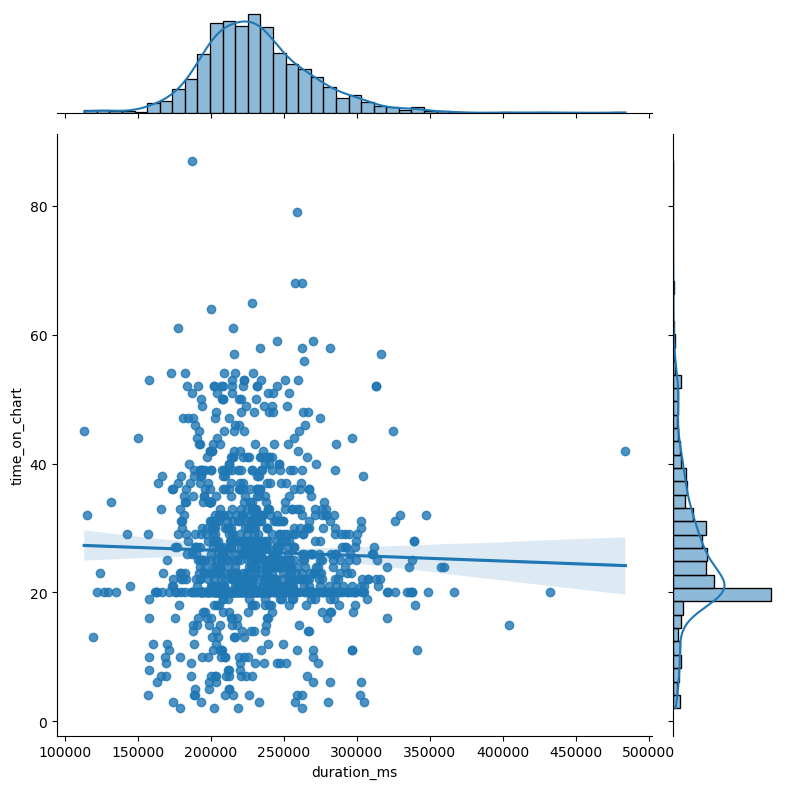

### Hypothesis:

$H_0$: There is no relationship between `duration_ms` to `time_on_chart`

$H_A$: There is a relationship between `duration_ms` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.029301798086126058`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between duration_ms and time_on_chart. (p-value: 0.3274)

<hr style="border:2px solid gray">

# Question #2:

# Does a higher year mean higher time_on_chart?

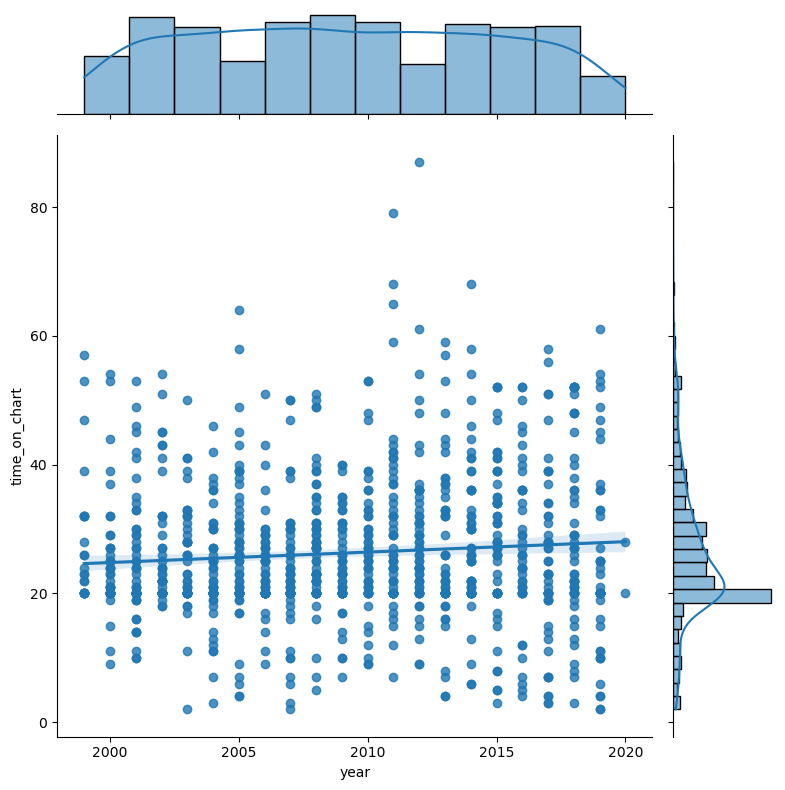

### Hypothesis:

$H_0$: There is no relationship between `year` to `time_on_chart`

$H_A$: There is a relationship between `year` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.08515576037947584`

### Results:

### Reject $H_0$

There exists some relationship between year and time_on_chart. (p-value: 0.0044)

<hr style="border:2px solid gray">

# Question #3:

# Does a higher popularity mean higher time_on_chart?

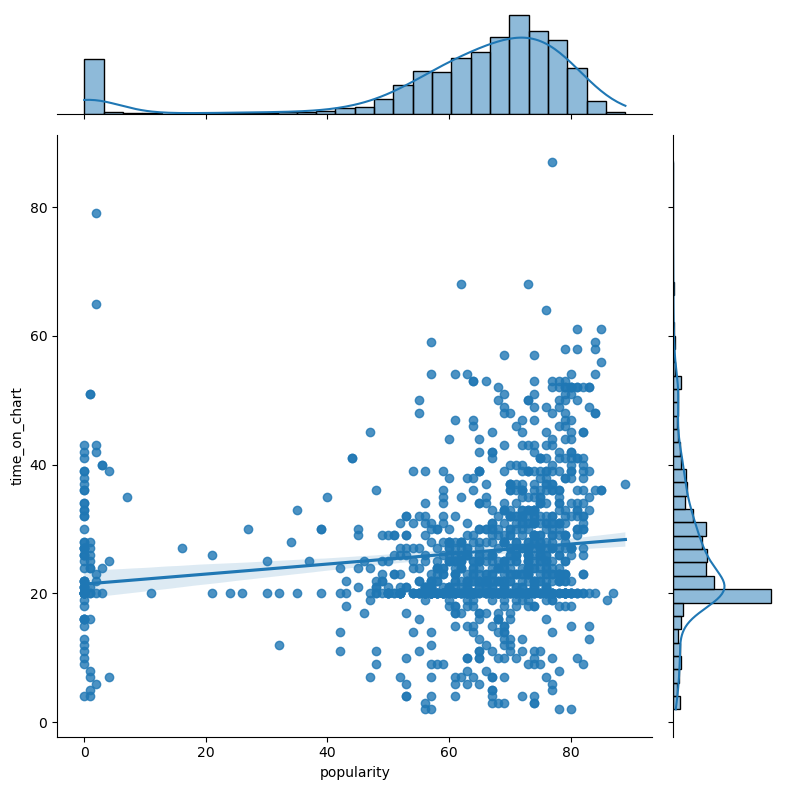

### Hypothesis:

$H_0$: There is no relationship between `popularity` to `time_on_chart`

$H_A$: There is a relationship between `popularity` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.14640714625454787`

### Results:

### Reject $H_0$

There exists some relationship between popularity and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #4:

# Does a higher danceability mean higher time_on_chart?

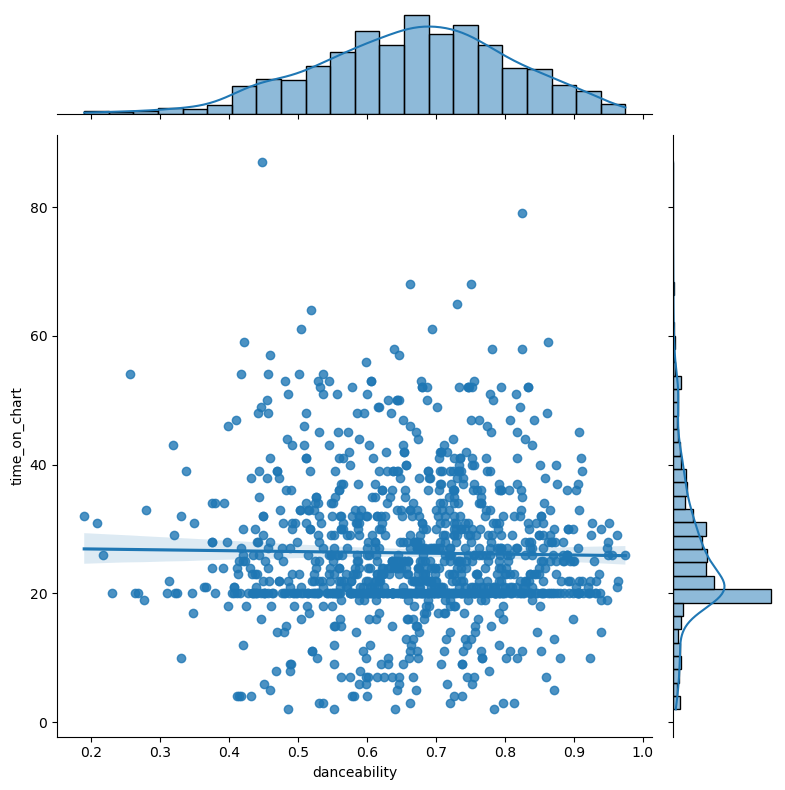

### Hypothesis:

$H_0$: There is no relationship between `danceability` to `time_on_chart`

$H_A$: There is a relationship between `danceability` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.017039593144861975`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between danceability and time_on_chart. (p-value: 0.5691)

<hr style="border:2px solid gray">

# Question #5:

# Does a higher energy mean higher time_on_chart?

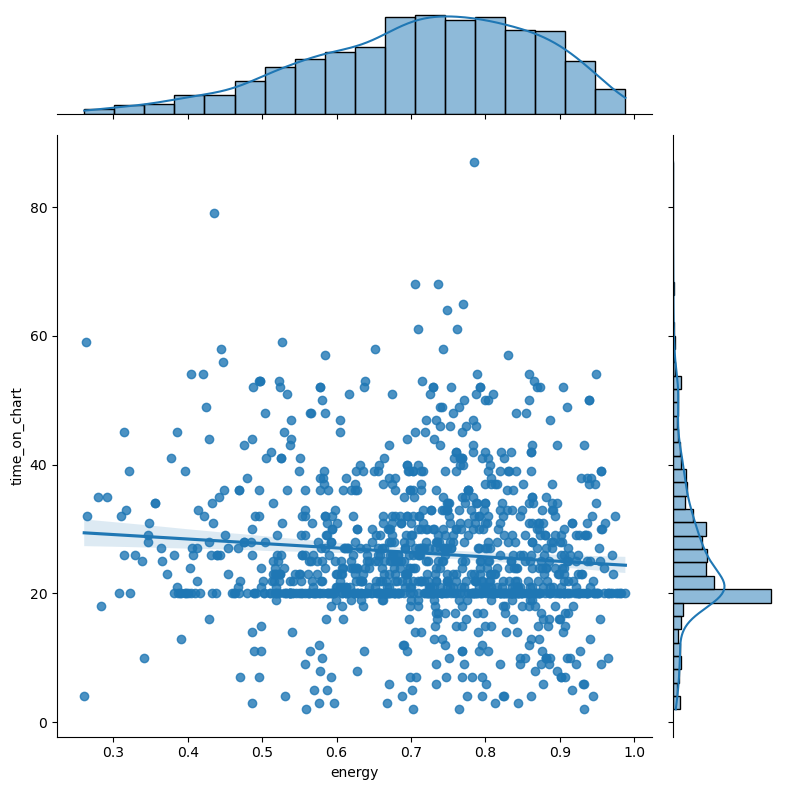

### Hypothesis:

$H_0$: There is no relationship between `energy` to `time_on_chart`

$H_A$: There is a relationship between `energy` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.09449067368126929`

### Results:

### Reject $H_0$

There exists some relationship between energy and time_on_chart. (p-value: 0.0016)

<hr style="border:2px solid gray">

# Question #6:

# Does a higher key mean higher time_on_chart?

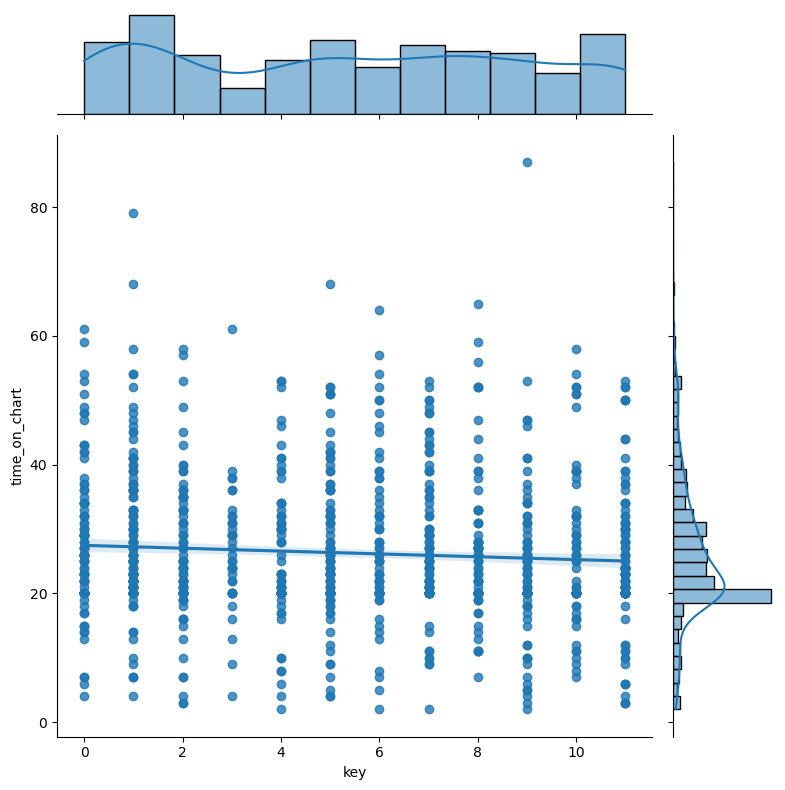

### Hypothesis:

$H_0$: There is no relationship between `key` to `time_on_chart`

$H_A$: There is a relationship between `key` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.07271433578230616`

### Results:

### Reject $H_0$

There exists some relationship between key and time_on_chart. (p-value: 0.0150)

<hr style="border:2px solid gray">

# Question #7:

# Does a higher loudness mean higher time_on_chart?

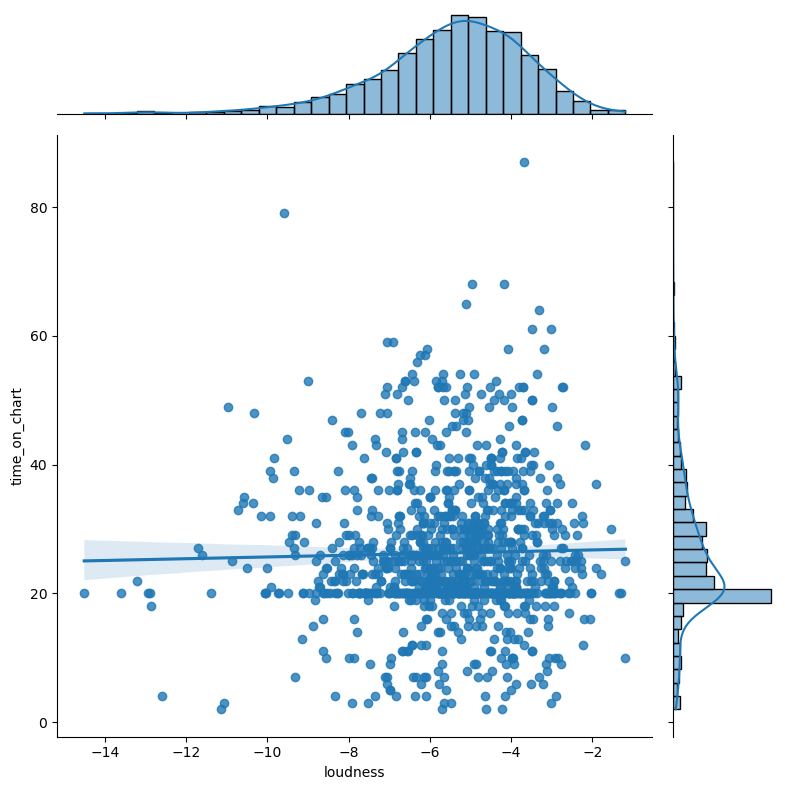

### Hypothesis:

$H_0$: There is no relationship between `loudness` to `time_on_chart`

$H_A$: There is a relationship between `loudness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.022961801860786453`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between loudness and time_on_chart. (p-value: 0.4429)

<hr style="border:2px solid gray">

write code for different test


# Question #9:

# Does a higher speechiness mean higher time_on_chart?

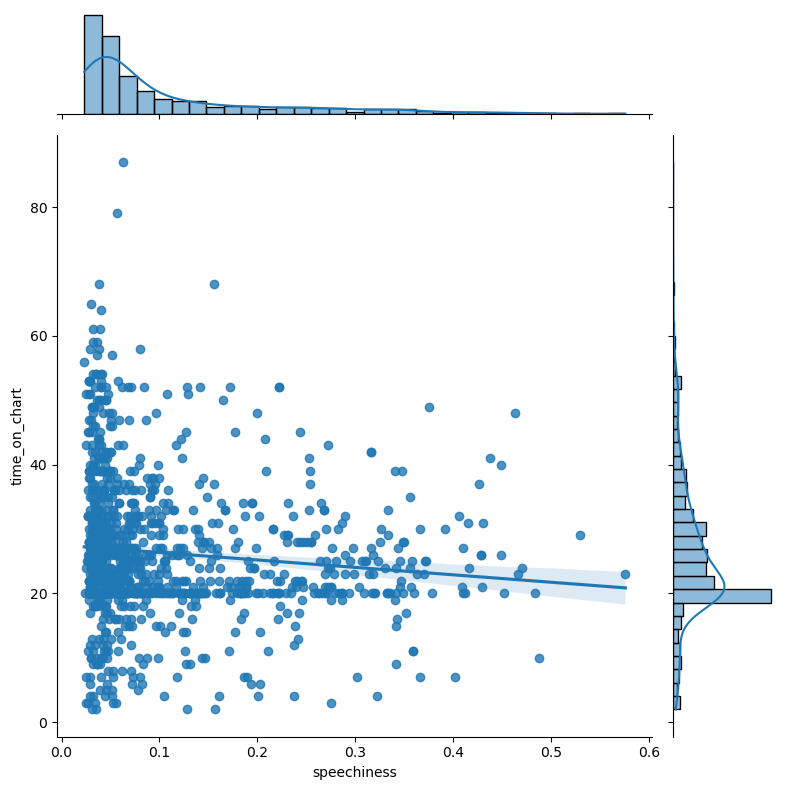

### Hypothesis:

$H_0$: There is no relationship between `speechiness` to `time_on_chart`

$H_A$: There is a relationship between `speechiness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.10471269663659986`

### Results:

### Reject $H_0$

There exists some relationship between speechiness and time_on_chart. (p-value: 0.0005)

<hr style="border:2px solid gray">

# Question #10:

# Does a higher acousticness mean higher time_on_chart?

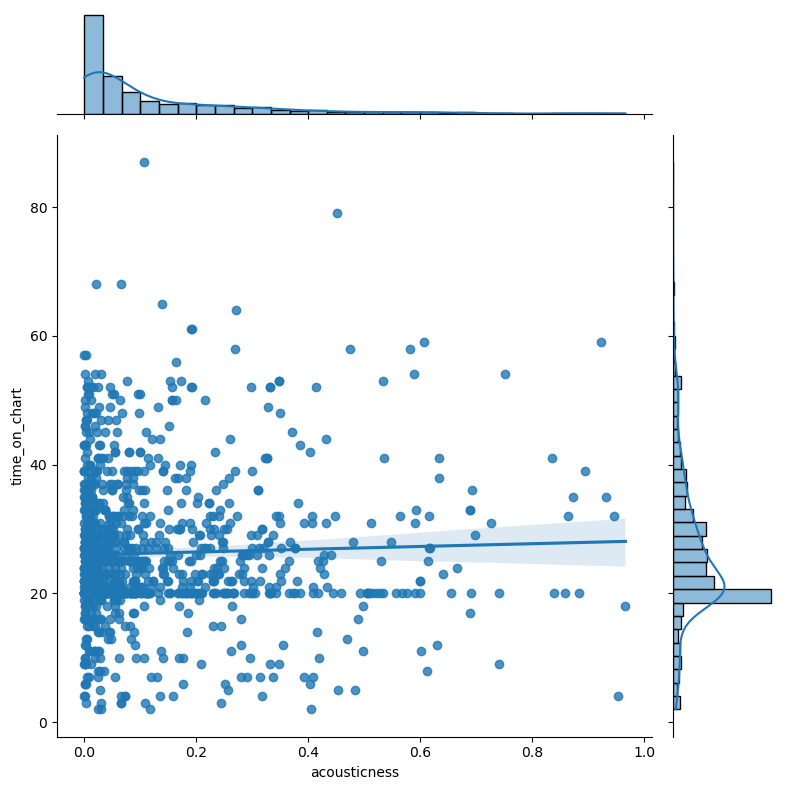

### Hypothesis:

$H_0$: There is no relationship between `acousticness` to `time_on_chart`

$H_A$: There is a relationship between `acousticness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.03377985551602524`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between acousticness and time_on_chart. (p-value: 0.2589)

<hr style="border:2px solid gray">

# Question #11:

# Does a higher instrumentalness mean higher time_on_chart?

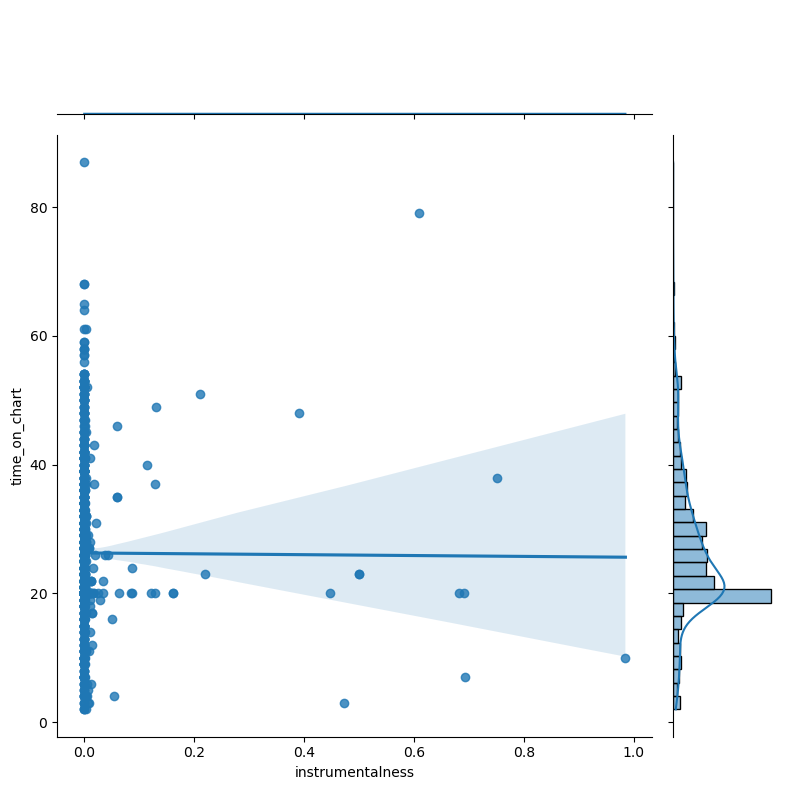

### Hypothesis:

$H_0$: There is no relationship between `instrumentalness` to `time_on_chart`

$H_A$: There is a relationship between `instrumentalness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.0039098680740875386`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between instrumentalness and time_on_chart. (p-value: 0.8961)

<hr style="border:2px solid gray">

# Question #12:

# Does a higher liveness mean higher time_on_chart?

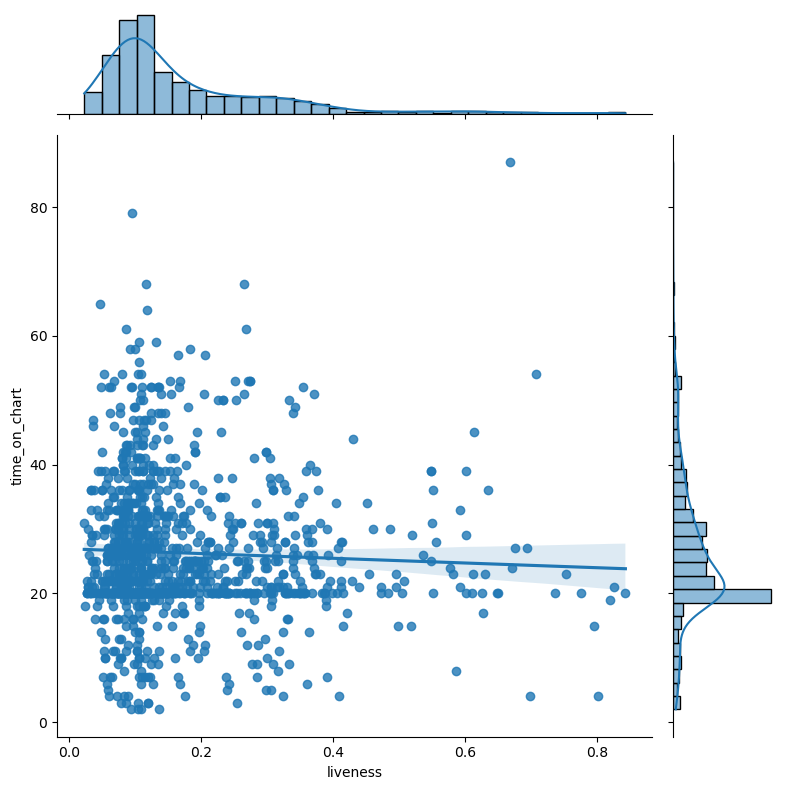

### Hypothesis:

$H_0$: There is no relationship between `liveness` to `time_on_chart`

$H_A$: There is a relationship between `liveness` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.04477949881438156`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between liveness and time_on_chart. (p-value: 0.1344)

<hr style="border:2px solid gray">

# Question #13:

# Does a higher valence mean higher time_on_chart?

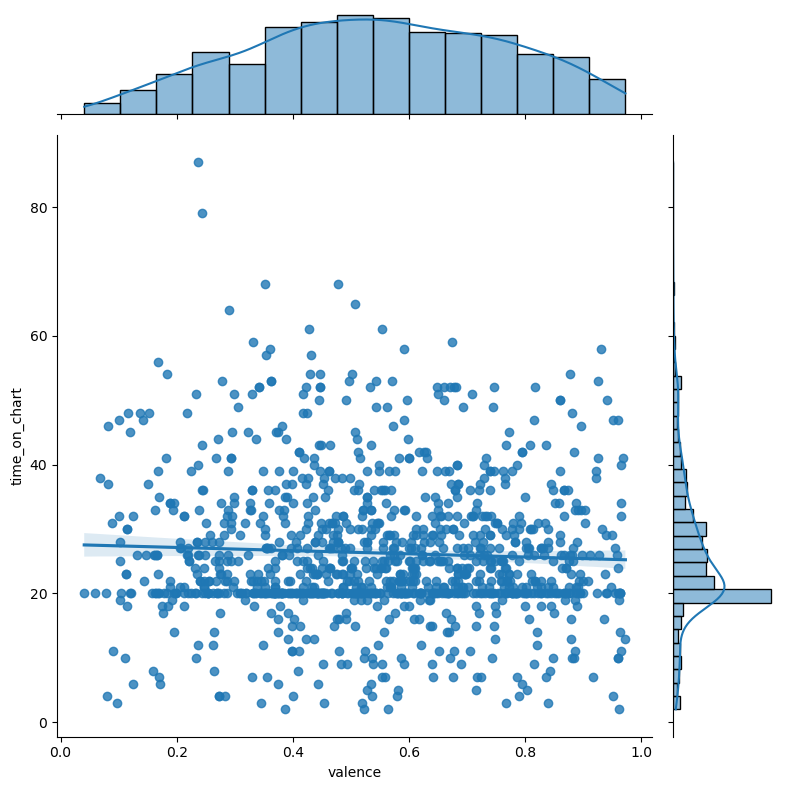

### Hypothesis:

$H_0$: There is no relationship between `valence` to `time_on_chart`

$H_A$: There is a relationship between `valence` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.048658073003431425`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between valence and time_on_chart. (p-value: 0.1038)

<hr style="border:2px solid gray">

# Question #14:

# Does a higher tempo mean higher time_on_chart?

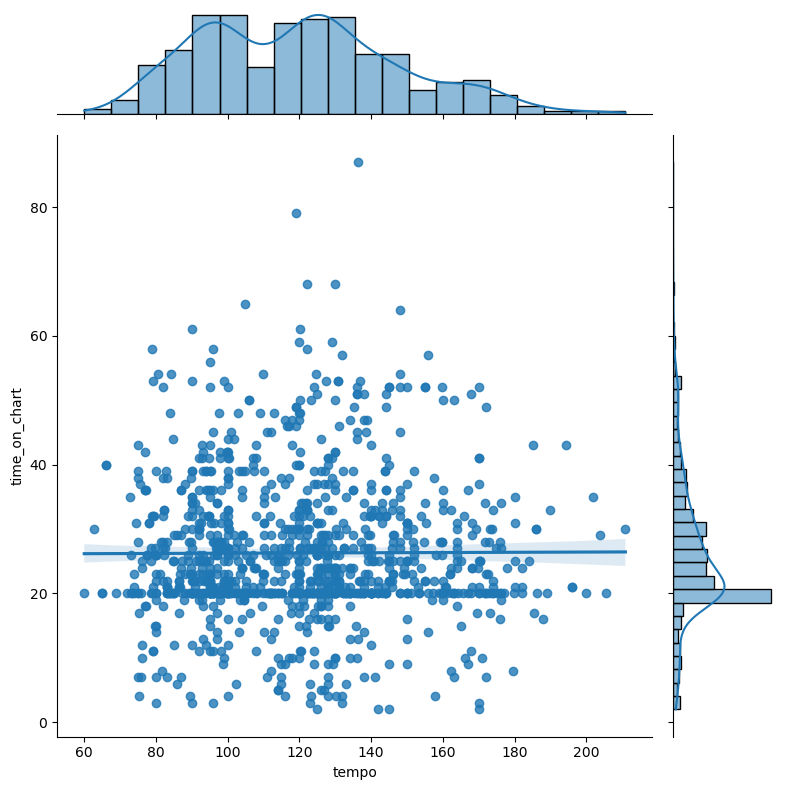

### Hypothesis:

$H_0$: There is no relationship between `tempo` to `time_on_chart`

$H_A$: There is a relationship between `tempo` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.004550615639695118`

### Results:

### Failed to Reject $H_0$

There is not a significant relationship between tempo and time_on_chart. (p-value: 0.8791)

<hr style="border:2px solid gray">

# Question #15:

# Does a higher chart_position mean higher time_on_chart?

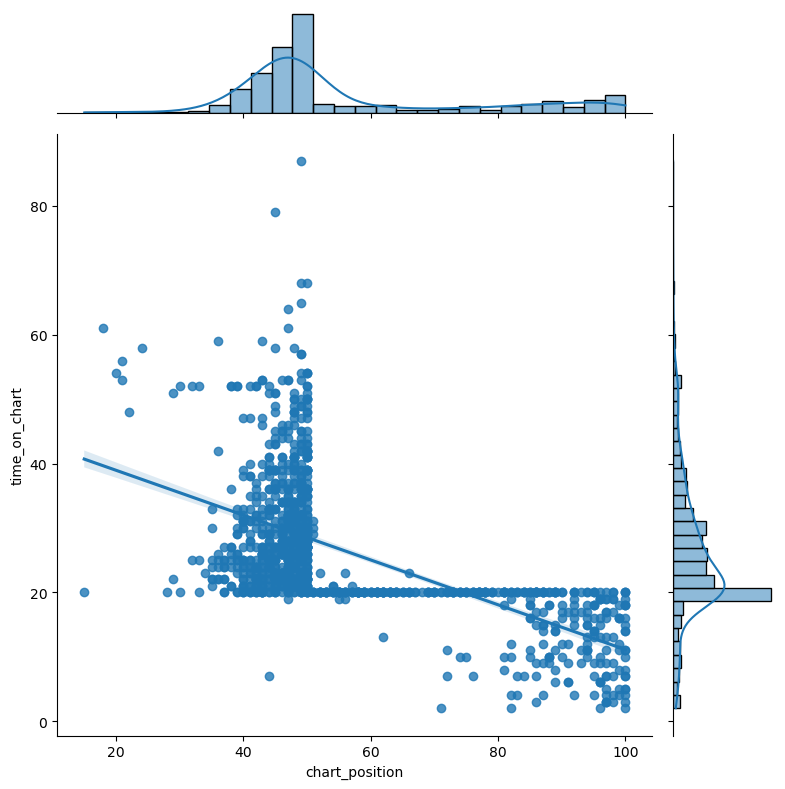

### Hypothesis:

$H_0$: There is no relationship between `chart_position` to `time_on_chart`

$H_A$: There is a relationship between `chart_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5898503532806659`

### Results:

### Reject $H_0$

There exists some relationship between chart_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

write code for different test


# Question #17:

# Does a higher time_on_chart mean higher time_on_chart?

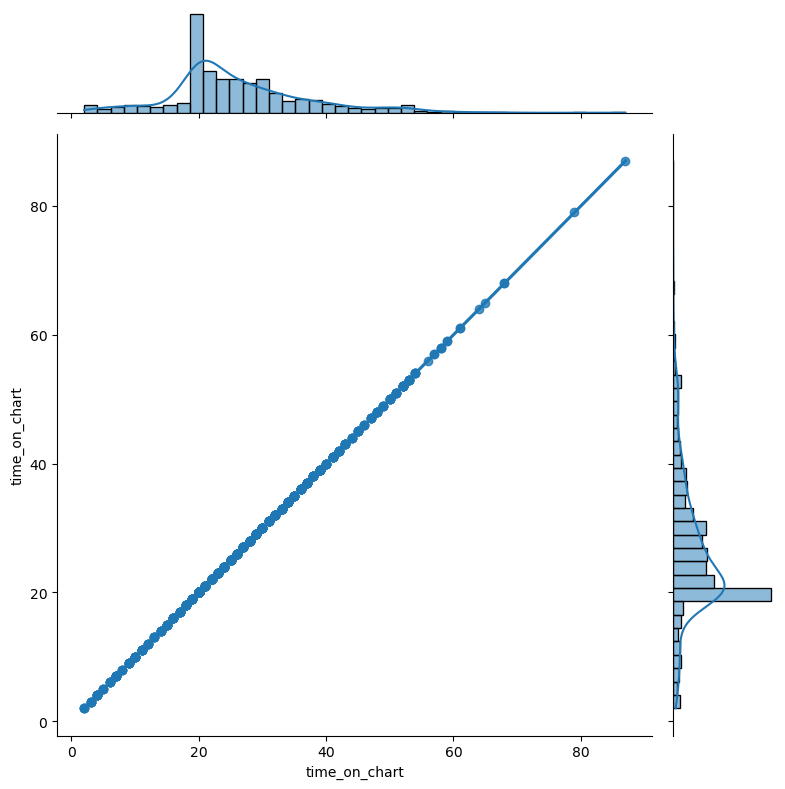

### Hypothesis:

$H_0$: There is no relationship between `time_on_chart` to `time_on_chart`

$H_A$: There is a relationship between `time_on_chart` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 1.0`

### Results:

### Reject $H_0$

There exists some relationship between time_on_chart and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #18:

# Does a higher consecutive_weeks mean higher time_on_chart?

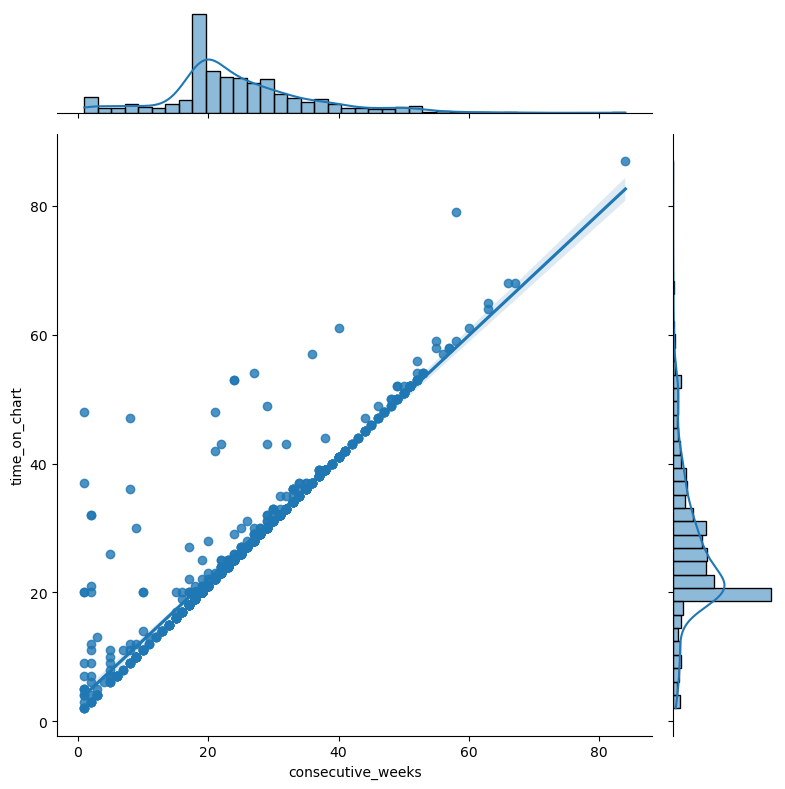

### Hypothesis:

$H_0$: There is no relationship between `consecutive_weeks` to `time_on_chart`

$H_A$: There is a relationship between `consecutive_weeks` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = 0.9433128833292955`

### Results:

### Reject $H_0$

There exists some relationship between consecutive_weeks and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #19:

# Does a higher previous_week mean higher time_on_chart?

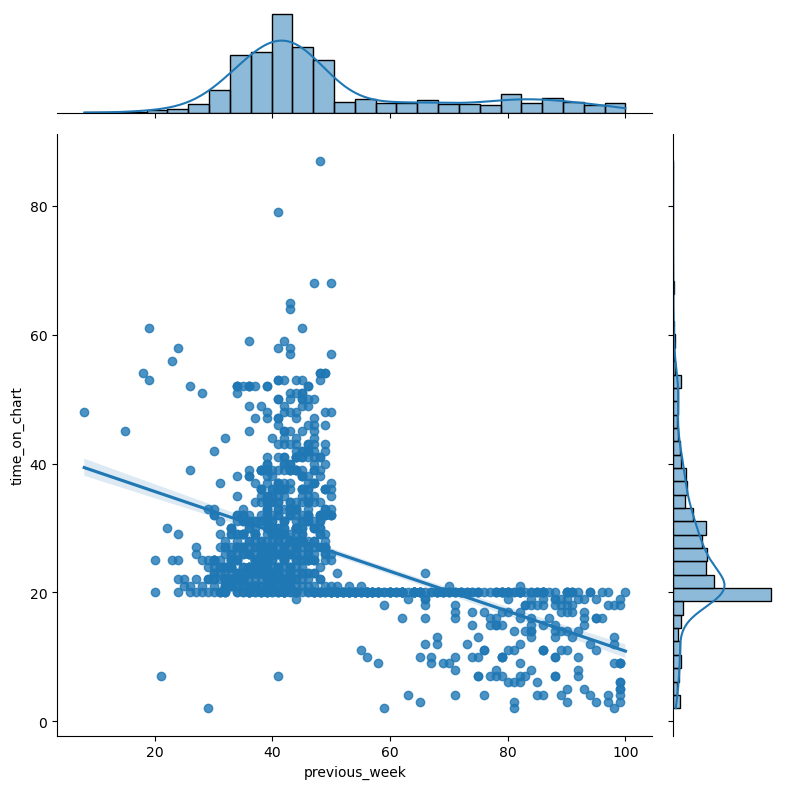

### Hypothesis:

$H_0$: There is no relationship between `previous_week` to `time_on_chart`

$H_A$: There is a relationship between `previous_week` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5175025456219732`

### Results:

### Reject $H_0$

There exists some relationship between previous_week and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #20:

# Does a higher peak_position mean higher time_on_chart?

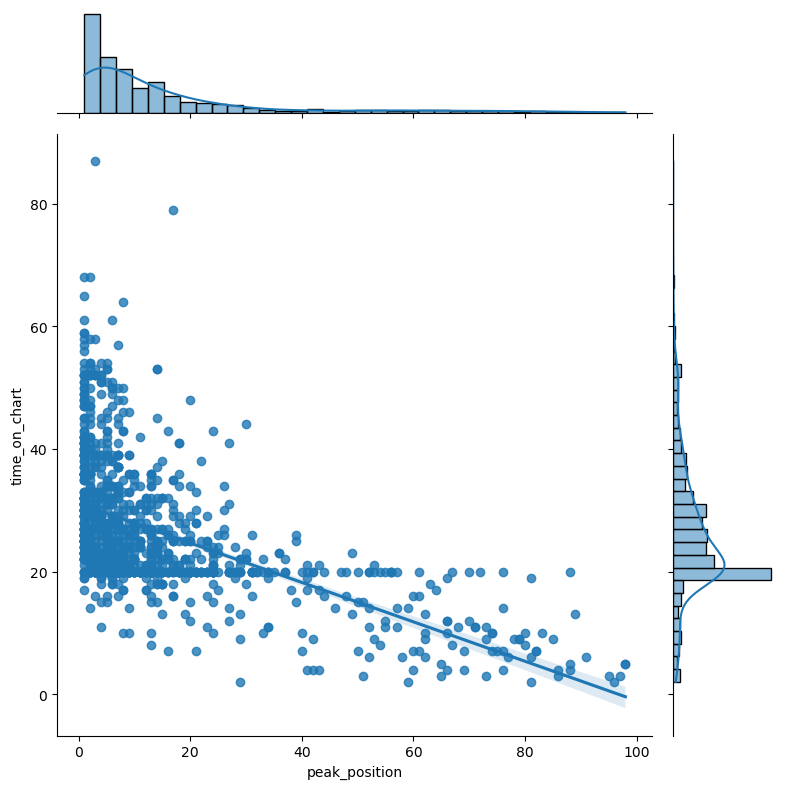

### Hypothesis:

$H_0$: There is no relationship between `peak_position` to `time_on_chart`

$H_A$: There is a relationship between `peak_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.5543648054633901`

### Results:

### Reject $H_0$

There exists some relationship between peak_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

# Question #21:

# Does a higher worst_position mean higher time_on_chart?

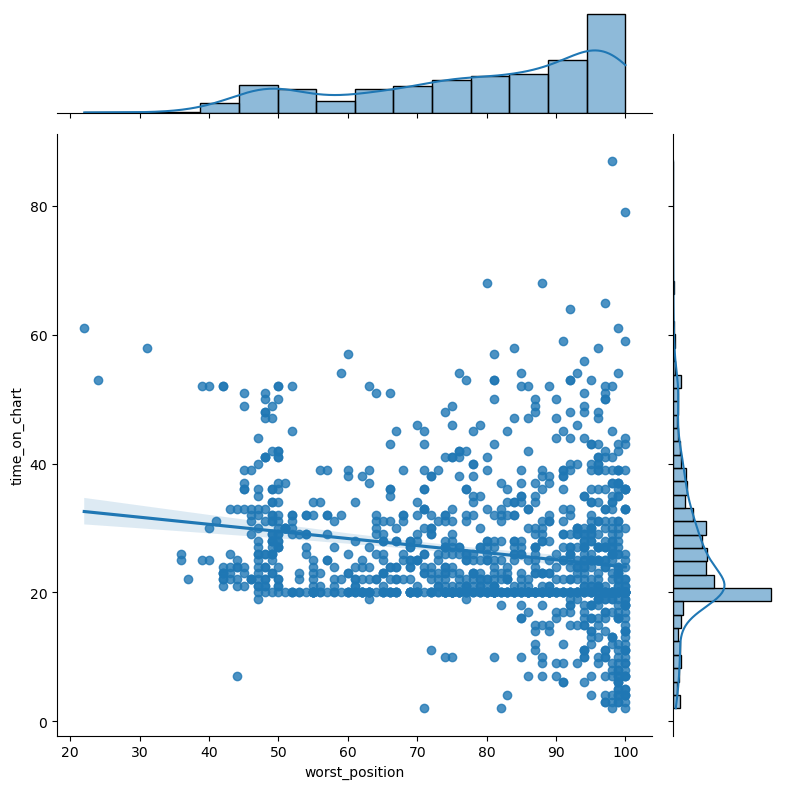

### Hypothesis:

$H_0$: There is no relationship between `worst_position` to `time_on_chart`

$H_A$: There is a relationship between `worst_position` and `time_on_chart` 

### Statistics Test:

### `Pearson's R = -0.17853680098392166`

### Results:

### Reject $H_0$

There exists some relationship between worst_position and time_on_chart. (p-value: 0.0000)

<hr style="border:2px solid gray">

In [33]:
num_columns_list = df.select_dtypes('number').columns
for num,feature in enumerate(num_columns_list):
    question_hypothesis_test((num+1),df,feature,target)

### Exploration Summary
* "Senior Citizen Status" was found to be a driver of "churn"
* "Tech Support" was found to be a driver of "churn" 
* Added feature "Total Addons" was found to be a driver of "churn" 

### Features I am moving to modeling With
* "Senior Citizen Status" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Tech Support" (small difference in churn percentage, but relationship to churn is statistically significant)
* "Total Addons" (moderate difference in churn percentage, and dependance is statistically significant)

# Model <a id="model"></a>
* I used RMSE as my evaluation metric
</br>

* churn makes up 26.54% of the data 
* by guessing not churn for every customer one could achieve an accuracy of 73.46%
* 73.46% will be the baseline accuracy I use for this project
</br>

* I will be evaluating models developed using three different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Pre-Process Obvious Continous Data Target Leakage

In [34]:
df = df.drop(columns = ['chart_position', 'instance','popularity',
       'consecutive_weeks', 'previous_week', 'peak_position',
       'worst_position'])

### Split

In [36]:
train, val, test = split_data(df)

(626, 22) (269, 22) (224, 22)


### Isolate

In [37]:
X_train, y_train = isolate_target(train,target)

(626, 21) (626,)


In [38]:
X_validate, y_validate = isolate_target(val,target)

(269, 21) (269,)


In [39]:
X_test, y_test = isolate_target(test,target)

(224, 21) (224,)


### Scale <a id="scale"></a>

<a id="definitions"></a> [Definitions](#scale_def)

In [40]:
X_train_scaled = scale_data(X_train)
X_validate_scaled = scale_data(X_validate)
X_test_scaled = scale_data(X_test)

### Dummies

[Definitions](#dummy_def) <a id="get_dummies"></a>

In [41]:
to_dummies = ['explicit']

In [42]:
X_train_scaled = dummies(X_train_scaled,to_dummies)
X_validate_scaled = dummies(X_validate_scaled,to_dummies)
X_test_scaled = dummies(X_test_scaled,to_dummies)

In [87]:
X_train_scaled

,duration_ms,energy,loudness,valence,acousticness,year,explicit,explicit,instrumentalness,mode,speechiness,explicit,explicit
144,0.467579,0.349381,0.554167,0.698185,0.252865,0.142857,True,True,0.000004,0.0,0.012757,True,True
3,0.349348,0.896836,0.761667,0.530014,0.027570,0.047619,False,False,0.000014,0.0,0.052372,False,False
1021,0.354017,0.745530,0.743417,0.628021,0.035650,0.809524,False,False,0.000000,1.0,0.126455,False,False
473,0.380265,0.665750,0.563833,0.565653,0.023583,0.428571,False,False,0.000053,0.0,0.113250,False,False
1035,0.361505,0.456671,0.687417,0.119056,0.178361,0.904762,False,False,0.000000,1.0,0.027753,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,0.355740,0.499312,0.797667,0.524446,0.403971,0.523810,False,False,0.000000,1.0,0.024843,False,False
666,0.461397,0.779917,0.674583,0.474329,0.003404,0.571429,False,False,0.000000,1.0,0.308415,False,False
965,0.377059,0.408528,0.647250,0.200356,0.462734,0.809524,True,True,0.000000,1.0,0.087735,True,True
890,0.393005,0.687758,0.646167,0.051119,0.101339,0.714286,True,True,0.000000,0.0,0.023724,True,True


### Models <a id="modeling"></a>

[Definitions](#model_def)

#### Step 1: Feature Selection Models

#### Method 1 - F-Regression

In [43]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [44]:
f_feature

['explicit', 'year', 'mode', 'speechiness']

#### Method 2: RFE

In [45]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train_scaled, y_train)

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['duration_ms', 'energy', 'loudness', 'valence']

In [79]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

ValueError: All arrays must be of the same length

#### Step 2: Keeping Best Features From Both Methods

In [63]:
# Keeping Rank >= 7
modeling_features = rfe_ranks_df[rfe_ranks_df['Rank']<=7].sort_values('Rank')
modeling_features = [modeling_features.iloc[i][0] for i in range(10)]
modeling_features.append(to_dummies)
modeling_features = flatten(modeling_features)

In [64]:
# removing uneeded features after RFE
X_train_scaled = X_train_scaled[modeling_features]
X_validate_scaled = X_validate_scaled[modeling_features]
X_test_scaled = X_test_scaled[modeling_features]

#### Step 3: Fit Models & Predict

In [65]:
# Linear Model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
preds['linear'] = lm.predict(X_train_scaled)

In [68]:
preds

,linear,lasso_lars,Tweedie,actual,baseline
0,23.066585,25.785942,23.072080,NaN,25.785942
1,24.107407,25.785942,24.094143,23.0,25.785942
2,28.060050,25.785942,28.094595,NaN,25.785942
3,24.464882,25.785942,24.418431,20.0,25.785942
4,31.022462,25.785942,31.508637,NaN,25.785942
...,...,...,...,...,...
621,29.256422,25.785942,29.385179,NaN,25.785942
622,26.458961,25.785942,26.383899,NaN,25.785942
623,27.654149,25.785942,27.570675,25.0,25.785942
624,25.052279,25.785942,24.964206,NaN,25.785942


<a id="lasso"></a> [Definitions](#scale_def)

In [54]:
# Specific Scaling for Lasso Lars
X_train_lasso_scale = scale_data(X_train,mode="standard")
X_train_lasso_scale = dummies(X_train_lasso_scale,to_dummies)

# Lasso Lars Model
lars = LassoLars(alpha=1.0)
lars.fit(X_train_lasso_scale, y_train)
preds['lasso_lars'] = lars.predict(X_train_lasso_scale)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [55]:
# Tweedie Model
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train_scaled, y_train)
preds['Tweedie'] = glm.predict(X_train_scaled)

### Comparing Models

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

* I have chosen to move forward to the test set with the Random Forest model

### Evaluate <a id="evaluate"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Baseline

In [56]:
# Baseline
preds['actual'] = y_train
preds['baseline'] = y_train.mean()

In [58]:
preds

,linear,lasso_lars,Tweedie,actual,baseline
0,23.066585,25.785942,23.072080,NaN,25.785942
1,24.107407,25.785942,24.094143,23.0,25.785942
2,28.060050,25.785942,28.094595,NaN,25.785942
3,24.464882,25.785942,24.418431,20.0,25.785942
4,31.022462,25.785942,31.508637,NaN,25.785942
...,...,...,...,...,...
621,29.256422,25.785942,29.385179,NaN,25.785942
622,26.458961,25.785942,26.383899,NaN,25.785942
623,27.654149,25.785942,27.570675,25.0,25.785942
624,25.052279,25.785942,24.964206,NaN,25.785942


In [57]:
# Baseline RMSE Metric
print(f"Baseline RMSE = {(sqrt(mean_squared_error(preds['actual'], preds['baseline'])))}")

ValueError: Input contains NaN.

In [72]:
# Linear RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['linear']))

ValueError: Input contains NaN.

In [73]:
#  RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['lasso_lars']))

ValueError: Input contains NaN.

In [74]:
#  RMSE Metric
sqrt(mean_squared_error(preds['actual'], preds['Tweedie']))

ValueError: Input contains NaN.

In [75]:
preds

,linear,lasso_lars,Tweedie,actual,baseline
0,23.066585,25.785942,23.072080,NaN,25.785942
1,24.107407,25.785942,24.094143,23.0,25.785942
2,28.060050,25.785942,28.094595,NaN,25.785942
3,24.464882,25.785942,24.418431,20.0,25.785942
4,31.022462,25.785942,31.508637,NaN,25.785942
...,...,...,...,...,...
621,29.256422,25.785942,29.385179,NaN,25.785942
622,26.458961,25.785942,26.383899,NaN,25.785942
623,27.654149,25.785942,27.570675,25.0,25.785942
624,25.052279,25.785942,24.964206,NaN,25.785942


### Test <a id="test"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Modeling Summary

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

# Conclusion <a id="conclusion"></a>
### Exploration

* Total churn = 1869 out of 7043 customers.
* 26.5% Churned
* 73.5% Not Churned

### Modeling

* Out of the Random Forest, KNN, and Logistic Regression models Random Forest performed higher than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

# Takeaways <a id="takeaways"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [84]:
df.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'genre', 'song_id',
       'time_on_chart', 'chart_debut', 'chart_url', 'date'],
      dtype='object')

# Next Steps <a id="takeaways"></a>
* Explore further combinations of features
* Implement clustering in exploration phasew
* Look for ways to calculate 